In [67]:
# import required libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.mx.model.deepar import DeepAREstimator 
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.model.predictor import Predictor

In [68]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [69]:
# paths to data 
# downloaded from https://eatradingacademy.com/software/forex-historical-data/
paths = ["C:/Users/kshiv/OneDrive/Desktop/DeepVar/data/AUDUSD1440.csv",
         "C:/Users/kshiv/OneDrive/Desktop/DeepVar/data/GBPUSD1440.csv",
         "C:/Users/kshiv/OneDrive/Desktop/DeepVar/data/USDJPY1440.csv",
         "C:/Users/kshiv/OneDrive/Desktop/DeepVar/data/EURUSD1440.csv"]

In [70]:
def read_asset_data(path):
    
    ''' function to read a csv file
    with colums:[Time,Open,High,Low,Close,Volume]
    returning a pandas dataframe with index the "Time" and 
    column the "Close" price of the given asset'''
    
    # read csv
    asset = pd.read_csv(path, delimiter='\t', usecols=[0,4],names=['datetime','price'])
    asset.datetime = pd.to_datetime(asset.datetime)
    # set datetime as index
    asset.set_index('datetime', inplace=True)
    asset_name = "".join(re.findall("[a-zA-Z]+", path))[-9:-3]
    asset.rename(columns={"price": asset_name}, inplace=True)
    
    return asset[[asset_name]]

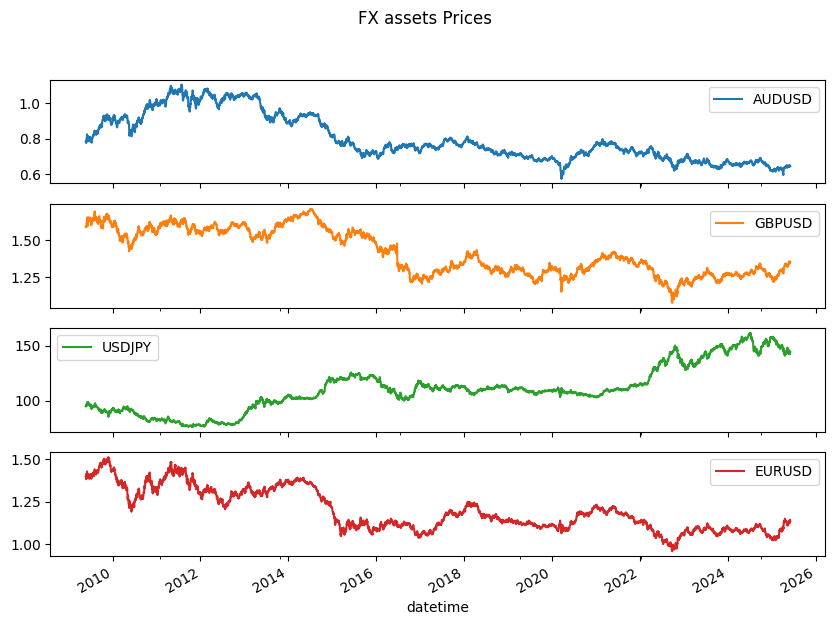

In [71]:
h = {}
# read all data
for i in range(len(paths)):
    h["asset" + str(i)] = read_asset_data(paths[i])
    
# Concat FX prices to one dataframe
prices = pd.concat(h, axis=1)
prices.columns = prices.columns.droplevel()
#prices.fillna(method='pad', axis=0, limit=2,inplace=True)
prices = prices.dropna()
#plot
prices.plot(subplots=True, title='FX assets Prices',figsize=(10, 7))
plt.show()

In [72]:
prices.tail()

,AUDUSD,GBPUSD,USDJPY,EURUSD
datetime,,,,
2025-05-30,0.64283,1.34532,144.006,1.13453
2025-06-01,0.64424,1.34679,143.792,1.13526
2025-06-02,0.64982,1.35567,142.425,1.14531
2025-06-03,0.64638,1.35300,143.818,1.13840
2025-06-04,0.64558,1.35118,144.253,1.13664


In [73]:
# asset returns calculation
returns = prices.pct_change().dropna()
# deepar model requires datetime index with constant frequency as input
returns = returns.asfreq(freq='1D', fill_value=0.0)
# we use the last 6 years of the data
returns = returns[returns.index>='2015-01-01']

In [74]:
returns.tail()

,AUDUSD,GBPUSD,USDJPY,EURUSD
datetime,,,,
2025-05-31,0.000000,0.000000,0.000000,0.000000
2025-06-01,0.002193,0.001093,-0.001486,0.000643
2025-06-02,0.008661,0.006593,-0.009507,0.008853
2025-06-03,-0.005294,-0.001970,0.009781,-0.006033
2025-06-04,-0.001238,-0.001345,0.003025,-0.001546


In [75]:
class DeepARModel:
    
    '''Class to ease fitting and predicting with GluonTS DeepAR estimator '''
    
    def __init__(self, freq='1D', context_length=15, prediction_length=10,
                 epochs=5, learning_rate=1e-4, n_layers=2., dropout=0.1):

        self.freq = freq
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_layers = n_layers
        self.dropout = dropout

    def df_to_np(self, ts):
        return ts.to_numpy().T

    def list_dataset(self, ts, train=True):
        
        '''expects as input a pandas df with datetime index and 
        columns the asset returns and outputs the train or test dataset in 
        a proper form to be used as intput to a GluonTS estimator'''
        
        custom_dataset = self.df_to_np(ts)
        start = pd.Timestamp(ts.index[0])
        if train == True:
            ds = ListDataset([{'target': x, 'start': start}
                              for x in custom_dataset[:, :-self.prediction_length]],
                             freq=self.freq)
        else:
            ds = ListDataset([{'target': x, 'start': start}
                              for x in custom_dataset],
                             freq=self.freq)
        return ds

    def fit(self, ts):
        
        '''expects as input a pandas df with datetime index and 
        columns the returns of the assets to be predicted'''
        # iniallize deepar estimator
        estimator = DeepAREstimator(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            freq=self.freq,
            trainer=Trainer(epochs=self.epochs,
                            ctx="cpu",
                            learning_rate=self.learning_rate,
                            num_batches_per_epoch=50,
                            ),
            num_layers=self.n_layers,
            dropout_rate=self.dropout,
            cell_type='lstm',
            num_cells=50
        )
        # prepare training data
        list_ds = self.list_dataset(ts, train=True)
        # train deepar on training data
        predictor = estimator.train(list_ds)
        return predictor

    def predict(self, ts ):
        '''expects as input a pandas df with datetime index and 
        columns the returns of the assets to be predicted'''
        # get the test data in proper form
        test_ds = self.list_dataset(ts, train=False)
        return self.estimator.predict(test_ds, num_samples=1000)


   

def make_forecasts(predictor, test_data, n_sampl):
    """takes a  predictor, gluonTS test data and the number of samples
    and returns MC samples for each datetime of the test set"""
    forecasts = []
    tss = []
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data,
        predictor=predictor,
        num_samples=n_sampl
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    return forecasts, tss

def plot_prob_forecasts(ts_entry, forecast_entry, asset_name, plot_length=20):
    prediction_intervals = (0.99, 0.95)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(intervals=prediction_intervals, color='g',ax=ax)
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.title(f'Forecast of {asset_name} series Returns')
    plt.show()

In [76]:
import pandas as pd
import numpy as np
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.mx.trainer import Trainer # Ensure Trainer is imported


# --- Make sure your 'returns' variable is loaded and prepared before this point ---
# 'returns' is now assumed to be a pandas DataFrame where each column is a time series
# and the index is a DatetimeIndex.

# --- Crucial: Convert your 'returns' data (pandas DataFrame) to GluonTS ListDataset ---

# 1. Define the frequency of your data (daily in this case)
freq_str = "D"

# 2. Validate 'returns' DataFrame
if not isinstance(returns, pd.DataFrame):
    raise ValueError("The 'returns' variable is expected to be a pandas DataFrame.")
if not isinstance(returns.index, pd.DatetimeIndex):
    raise ValueError("The index of the 'returns' DataFrame must be a pandas DatetimeIndex.")
if not returns.columns.is_unique:
    raise ValueError("Column names in the 'returns' DataFrame must be unique to be used as item_ids.")


# 3. Create the ListDataset by iterating over columns in the DataFrame
dataset_entries = []
for column_name in returns.columns:
    time_series_values = returns[column_name].values.astype(np.float32)
    start_time = returns.index[0] # Assumes all series start at the same time

    # Skip empty series if any (e.g., all NaNs after some processing)
    if np.isnan(time_series_values).all():
        print(f"Skipping empty series: {column_name}")
        continue

    dataset_entries.append({
        FieldName.TARGET: time_series_values,
        FieldName.START: start_time,
        FieldName.ITEM_ID: column_name # Use column name as item_id
    })

if not dataset_entries:
    raise ValueError("No valid time series found in the 'returns' DataFrame to create a ListDataset.")

training_data = ListDataset(dataset_entries, freq=freq_str)
# --- End of data conversion ---

# Now, define and train the DeepAR estimator (this part remains the same)
estimator = DeepAREstimator(
    freq=freq_str,
    prediction_length=10,
    context_length=15,
    trainer=Trainer(epochs=5)
)

print("Starting model training...")
try:
    predictor = estimator.train(training_data)
    print("Model training completed successfully.")
except RuntimeError as e:
    if "Could not infer dtype of numpy.int64" in str(e):
        print(f"RuntimeError during training: {e}")
        print("This might be related to the known numpy.int64 dtype issue with GluonTS.")
        print("Ensure all numerical data fed to the model is explicitly float32.")
    else:
        raise e # Re-raise other RuntimeErrors
except Exception as e:
    print(f"An unexpected error occurred during training: {e}")
    raise e # Re-raise other exceptions



Starting model training...


100%|██████████| 50/50 [00:02<00:00, 23.46it/s, epoch=5/5, avg_epoch_loss=-4.37]

Model training completed successfully.


c:\Users\kshiv\anaconda3\envs\varnet_py311\Lib\site-packages\gluonts\model\forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


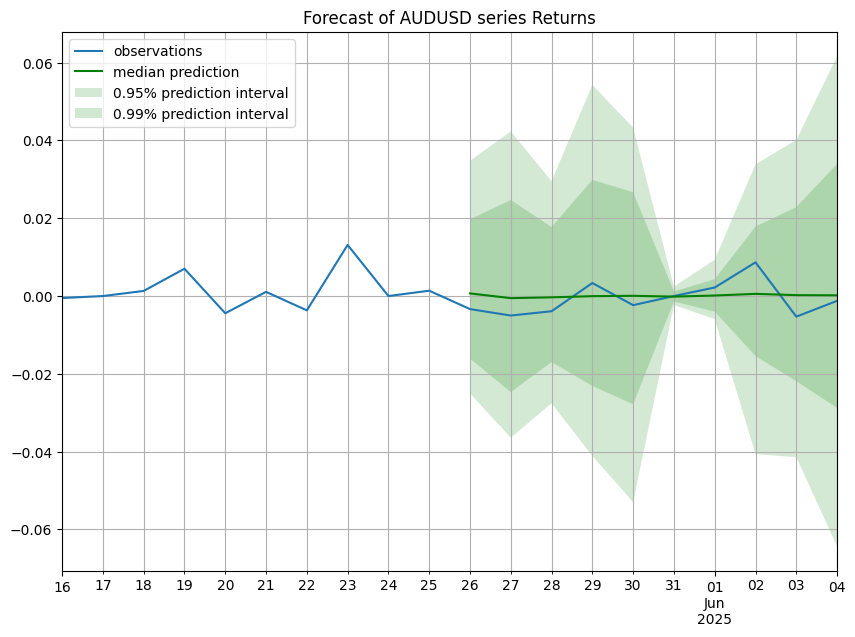

c:\Users\kshiv\anaconda3\envs\varnet_py311\Lib\site-packages\gluonts\model\forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


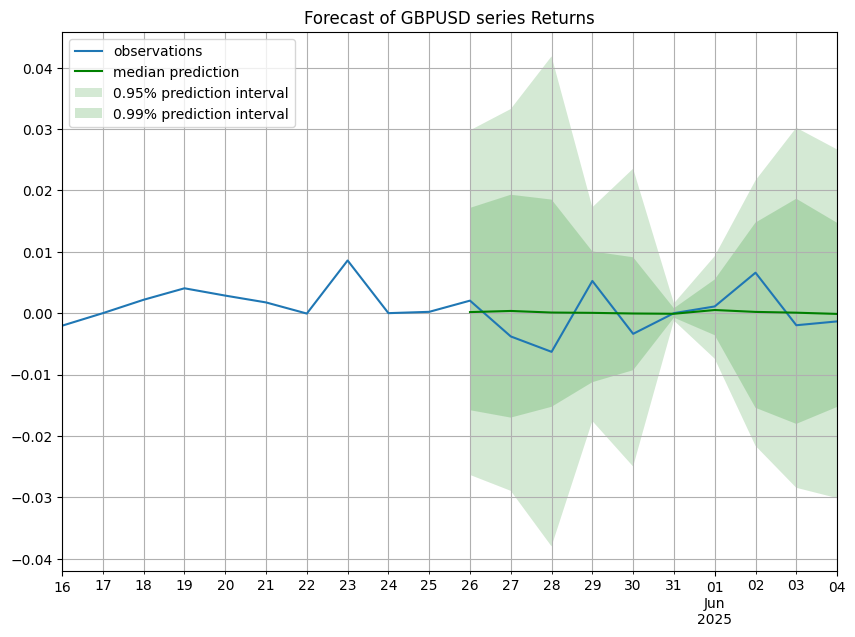

c:\Users\kshiv\anaconda3\envs\varnet_py311\Lib\site-packages\gluonts\model\forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


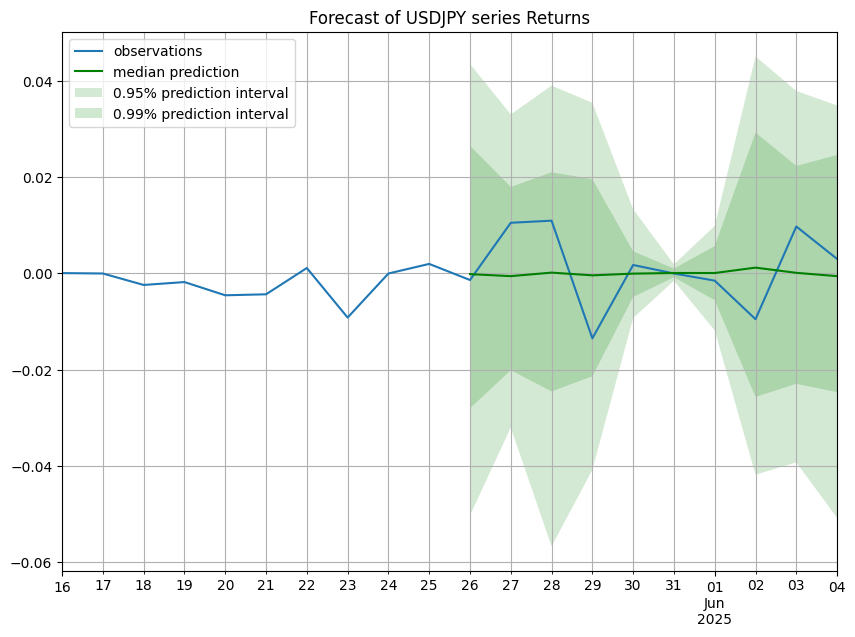

c:\Users\kshiv\anaconda3\envs\varnet_py311\Lib\site-packages\gluonts\model\forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


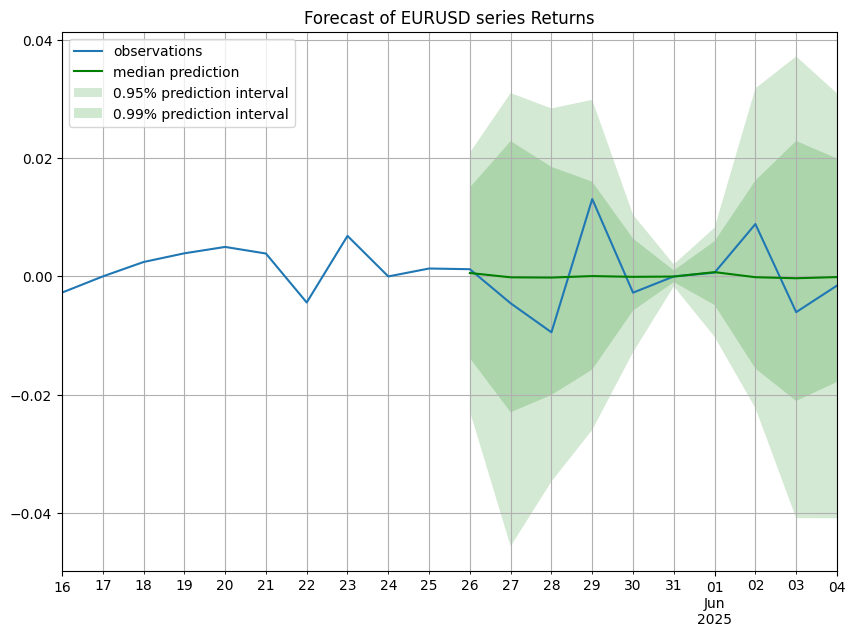

In [77]:
# get the test data
test_ds = DeepARModel(prediction_length=10, context_length=15, freq='D').list_dataset(returns, train=False)
# use the TRAINED PREDICTOR to make a probabilistic forecast for the next 10 days
# Ensure 'predictor' is the variable holding the result of 'estimator.train(training_data)'
forecasts, tss = make_forecasts(predictor, test_ds, n_sampl=1000) # <--- Use 'predictor' here
for i in range(len(forecasts)):
    plot_prob_forecasts(tss[i], forecasts[i], returns.columns[i])

As can be seen from the figures above, DeepAR generates a consistent probabilistic prediction for each of the input time series according to their estimated distribution. DeepVaR utilizes these forecasts to calculate both univariate VaR and portfolio's VaR.

In [78]:
def var_p(predictions, returns, weights, days_ahead=0, alpha=95): 
    
    '''takes as inputs the deepar sample predictions, 
    the dataframe with the asset returns, the portfolio weights, 
    the index of the predicted day and the confidence probability
    and returns the portfolio VaR of the given day'''
    
    V = np.zeros(len(weights))
    for i in range(len(weights)):
        if weights[i] < 0 :
            V[i] = weights[i] * np.percentile(predictions[i].samples[:,days_ahead], alpha)
        else:
            V[i] = weights[i] * np.percentile(predictions[i].samples[:,days_ahead], 100-alpha)
    R = returns.corr()
    return -np.sqrt(V @ R @ V.T)

The following plot depicts the DeepVaR predictions on 2020-12-08 for the next 10-days assuming portfolio with equal weights (0.25) on the 4 FX instruments. 

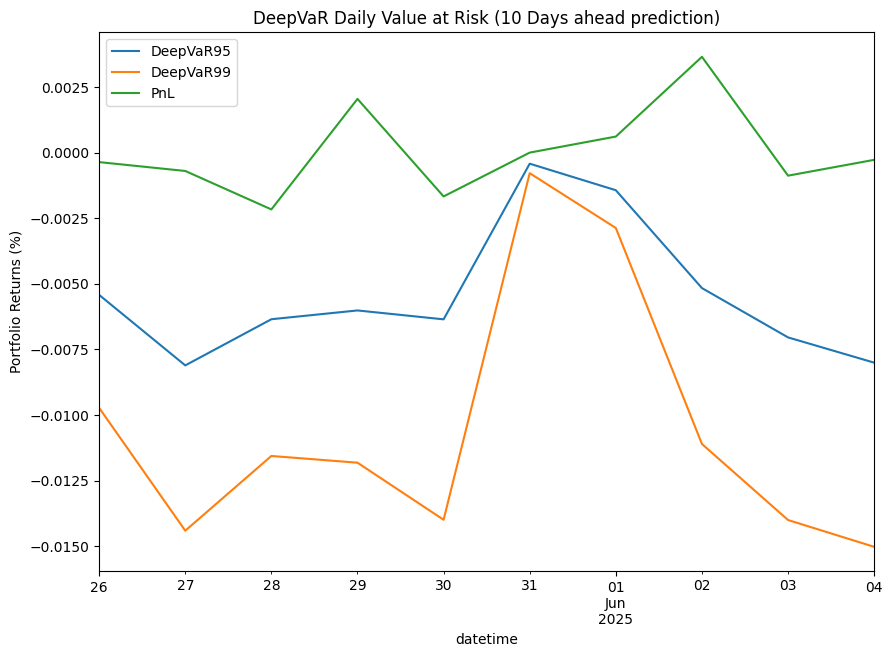

In [79]:
# portfolio weights vector
w = np.ones([4,1]) * 0.25  
# lists to save VaR predictions
var95 = []
var99 = []
for i in range(10):
    var95.append(var_p(forecasts,returns.iloc[-75:], w, i, alpha=95))
    var99.append(var_p(forecasts,returns.iloc[-75:], w, i, alpha=99))

pnl = (returns.iloc[-10:] @ w).values.flatten()

results = pd.DataFrame({'DeepVaR95':var95,'DeepVaR99':var99, 'PnL':pnl}, index=returns.index[-10:])
results.plot(figsize=(10, 7))
plt.title('DeepVaR Daily Value at Risk (10 Days ahead prediction)')
plt.ylabel('Portfolio Returns (%)')
plt.show()

In [80]:
class VaRCalculation:
    '''Python class to calculate VaR and ES.'''

    def __init__(self, time=1, alpha=95, freq=1):
        self.time = time
        self.alpha = alpha
        self.freq = freq

    def mc(self, x, alpha, n_sims=5000, seed=42):
        '''Monte Carlo VaR'''
        np.random.seed(seed)
        sim_returns = np.random.normal(x.mean(), x.std(), n_sims)
        return np.sqrt(self.time * self.freq) * np.percentile(sim_returns, alpha)

    def vc(self, x, alpha):
        '''Variance-covariance VaR'''
        from scipy import stats
        c = alpha / 100
        return np.sqrt(self.time * self.freq) * (x.std() * stats.norm.ppf(c))

    def hs(self, x, alpha):
        '''Historical Simulation VaR'''
        return np.sqrt(self.time * self.freq) * np.percentile(x, 100 - alpha)

    def es(self, x, alpha):
        '''Expected Shortfall'''
        from scipy import stats
        alpha = 1 - alpha / 100
        return - \
            (alpha ** -1 * stats.norm.pdf(stats.norm.ppf(alpha)) * x.std() * np.sqrt(
                self.time * self.freq) - x.mean()).flatten()[0]

    def predict(self, X, w):
        R = X.corr()
        var = {'vc': 0, 'hs': 0, 'mc': 0, 'es': 0}

        V = np.zeros(len(w))
        for i in range(len(w)):
            V[i] = np.abs(w[i]) * self.vc(X.iloc[:, i], alpha=self.alpha)
        var['vc'] = -np.sqrt(V @ R @ V.T)

        for i in range(len(w)):
            if w[i] < 0:
                V[i] = w[i] * self.hs(X.iloc[:, i], alpha=self.alpha)
            else:
                V[i] = w[i] * self.hs(X.iloc[:, i], alpha=100 - self.alpha)
        var['hs'] = -np.sqrt(V @ R @ V.T)

        for i in range(len(w)):
            if w[i] < 0:
                V[i] = w[i] * self.mc(X.iloc[:, i], alpha=self.alpha)
            else:
                V[i] = w[i] * self.mc(X.iloc[:, i], alpha=100 - self.alpha)
        var['mc'] = -np.sqrt(V @ R @ V.T)

        for i in range(len(w)):
            V[i] = np.abs(w[i]) * self.es(X.iloc[:, i], alpha=self.alpha)
        var['es'] = -np.sqrt(V @ R @ V.T)

        return var

In [81]:
# initialize empty lists to save results
deepvar95 = []
deepvar99 = []
vc95 = []
vc99 = []
hs95 = []
hs99 = []

# iterate over the test set
for i in range(10):
    # train the DeepAR estimator
    estimator = DeepARModel(prediction_length=1, context_length=15, epochs=5).fit(returns.iloc[:-10])
    # predict the distribution of returns for the next day
    predictions_it = estimator.predict(DeepARModel().list_dataset(returns.iloc[:-10+i], train=False), 1000)
    predictions = list(predictions_it)
    # calculate DeepVaR for the next day 
    deepvar95.append(var_p(predictions,returns.iloc[-260+i:-10+i], w, 0, alpha=95))
    deepvar99.append(var_p(predictions,returns.iloc[-260+i:-10+i], w, 0, alpha=99))
    # calculate VaR for the next day with both VC and HS methods
    var99 = VaRCalculation(time=1, alpha=99).predict(returns.iloc[-260+i:-10+i], w)
    var95 = VaRCalculation(time=1, alpha=95).predict(returns.iloc[-260+i:-10+i], w)
    vc95.append(var95['vc'])
    vc99.append(var99['vc'])
    hs95.append(var95['hs'])
    hs99.append(var99['hs'])


100%|██████████| 50/50 [00:03<00:00, 15.45it/s, epoch=5/5, avg_epoch_loss=-4.09]


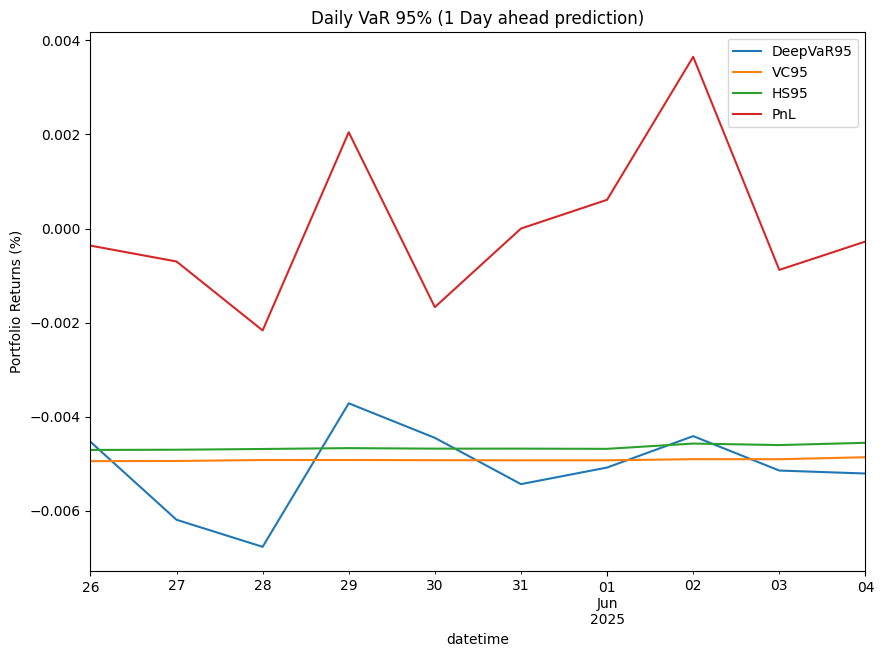

In [82]:
# plot results for 95% VaR
results = pd.DataFrame({'DeepVaR95':deepvar95,'VC95':vc95, 'HS95':hs95, 'PnL':pnl}, index=returns.index[-10:])
results.plot(figsize=(10, 7))
plt.title('Daily VaR 95% (1 Day ahead prediction)')
plt.ylabel('Portfolio Returns (%)')
plt.show()

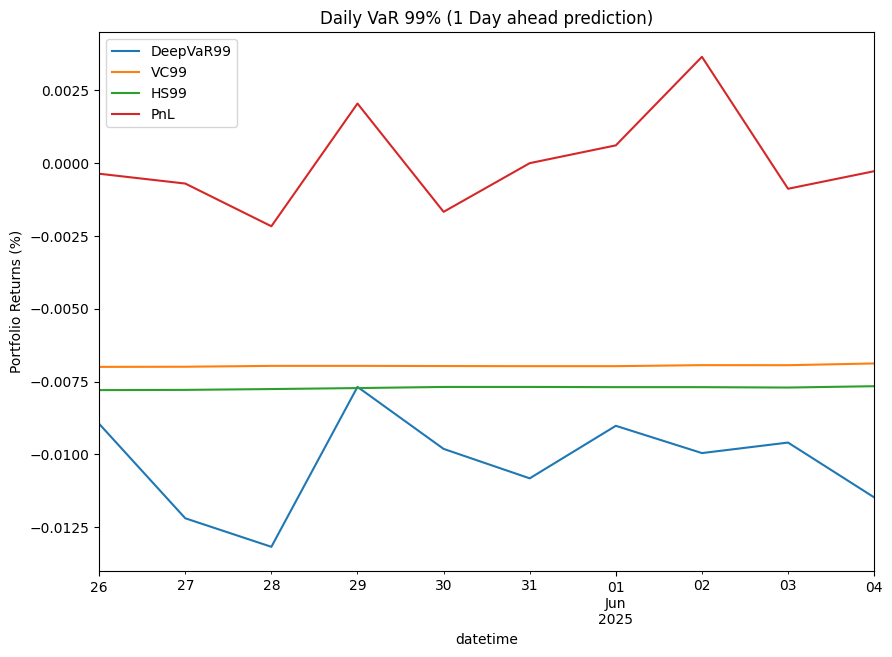

In [83]:
# plot results for 99% VaR
results = pd.DataFrame({'DeepVaR99':deepvar99,'VC99':vc99, 'HS99':hs99, 'PnL':pnl}, index=returns.index[-10:])
results.plot(figsize=(10, 7))
plt.title('Daily VaR 99% (1 Day ahead prediction)')
plt.ylabel('Portfolio Returns (%)')
plt.show()